## Comparison of Classic and Poisson Bootstrap in toy AB test

#### Bootstrap is a powerful technique from data analytics used mostly for AB testing, and its main disadvantage is computational complexity. That is why in such cases poisson bootstrap is used, the main idea is that when n>=100 poisson distribution approximates binomial: https://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap26.html

In [7]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

#### Main metric for test will be CTR, which equals `number_of_clicks/number_of_views`. Views are generated from lognormal distribution, click are from binominal distribution

In [8]:
N = 500000   ## N - number of observations(actions)

views = np.round(np.random.lognormal(size=N)).astype(int)
clicks = np.round(np.random.binomial(max(views), 1/(max(views)*3), size=N) + (np.random.random(N) > 0.9).astype(int))

user_ids = np.random.choice(range(N//10), N)
action_ids = range(N)

In [9]:
data = pd.DataFrame(
    {'action_id': action_ids, 
     'user_id': user_ids, 
     'views': views, 
     'clicks': clicks}
)
data = data[data['clicks'] <= data['views']]

In [4]:
data.head()

,action_id,user_id,views,clicks
0,0,33318,7,0
1,1,13430,1,0
2,2,41026,1,1
3,3,32149,1,0
4,4,34937,3,0


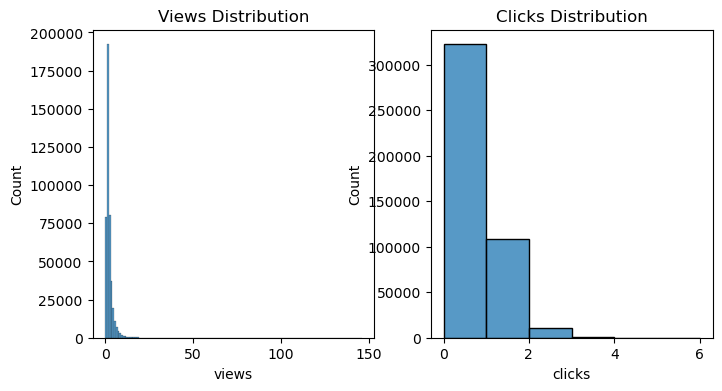

In [5]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data['views'], binwidth=1, ax=ax[0]);
ax[0].set_title('Views Distribution')

sns.histplot(data['clicks'], binwidth=1, ax=ax[1]);
ax[1].set_title('Clicks Distribution')

plt.show()

In [6]:
data = data.groupby('user_id', as_index=False)[['views', 'clicks']].sum()

In [7]:
data.head()

,user_id,views,clicks
0,0,8,0
1,1,11,6
2,2,20,3
3,3,19,3
4,4,9,2


In [10]:
mask = np.random.randint(0, 2, len(data)).astype(bool)   ## split dataset to control and treatment groups randomly

In [11]:
data.loc[mask, 'group'] = 'control'
data.loc[~mask, 'group'] = 'treatment'

In [10]:
data.head()

,user_id,views,clicks,group
0,0,8,0,control
1,1,11,6,control
2,2,20,3,treatment
3,3,19,3,control
4,4,9,2,control


In [11]:
data.groupby('group', as_index=False)[['views', 'clicks']].sum()   ## there is no disbalance in groups

,group,views,clicks
0,control,395652,64835
1,treatment,400687,66467


In [12]:
data.groupby('group', as_index=False)['clicks'].agg(   ## there is no disbalance in groups
    {'actual_clicks': lambda x: sum(x==0), 
     'no_clicks': lambda x: sum(x!=0)}
)

,group,actual_clicks,no_clicks
0,control,2255,22505
1,treatment,2250,22986


In [13]:
control = data[data['group'] == 'control'].copy()
treatment = data[data['group'] == 'treatment'].copy()

In [15]:
control_ctr = sum(control['clicks']) / sum(control['views']) * 100
treatment_ctr = sum(treatment['clicks']) / sum(treatment['views']) * 100

print(f'Control group ctr: {round(control_ctr, 2)} %')
print(f'Treatment group ctr: {round(treatment_ctr, 2)} %')
print(f'Difference: {treatment_ctr - control_ctr}')

Control group ctr: 16.39 %
Treatment group ctr: 16.59 %
Difference: 0.20138432913677207


In [172]:
## classical bootstrap
def bootstrap(control: pd.DataFrame, treatment: pd.DataFrame, B: int) -> List[int]:
    result = []
    
    for _ in range(B):
        control_bootstrapped = control.sample(replace=True, n=len(control))
        control_ctr = sum(control_bootstrapped['clicks']) / sum(control_bootstrapped['views']) * 100
        treatment_bootstrapped = treatment.sample(replace=True, n=len(treatment))
        treatment_ctr = sum(treatment_bootstrapped['clicks']) / sum(treatment_bootstrapped['views']) * 100
        result.append(treatment_ctr - control_ctr)
        
    return result    

In [173]:
## poisson bootstrap
def poisson_bootstrap(control: pd.DataFrame, treatment: pd.DataFrame, B: int) -> List[int]:
    control_result = np.zeros((B, 2))
    treatment_result = np.zeros((B, 2))
    
    for idx, row in pd.concat([control, treatment]).iterrows():
        poisson_weights = np.random.poisson(lam=1, size=B)
        if row['group'] == 'control':
            control_result[:, 0] += row['views'] * poisson_weights  
            control_result[:, 1] += row['clicks'] * poisson_weights 
        else:
            treatment_result[:, 0] += row['views'] * poisson_weights 
            treatment_result[:, 1] += row['clicks'] * poisson_weights 
        
    control_ctr = control_result[:, 1] / control_result[:, 0] * 100
    treatment_ctr = treatment_result[:, 1] / treatment_result[:, 0] * 100
    
    return treatment_ctr - control_ctr

In [174]:
%%timeit
bootstrap(control, treatment, 10000)

1min 2s ± 3.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [175]:
%%timeit
poisson_bootstrap(control, treatment, 10000)

19.7 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
bootstrap_results = bootstrap(control, treatment, 10000)
poisson_bootstrap_results = poisson_bootstrap(control, treatment, 10000)

In [180]:
print(f'Real difference: {treatment_ctr - control_ctr}')
print(f'Classic Bootstrap result difference: {np.mean(bootstrap_results)}')
print(f'Poisson Bootstrap result difference: {np.mean(poisson_bootstrap_results)}')

Real difference: 0.20138432913677207
Classic Bootstrap result difference: 0.20120800265972544
Poisson Bootstrap result difference: 0.2016645673796625


Text(0.5, 1.0, 'Poisson Bootstrap results distribution')

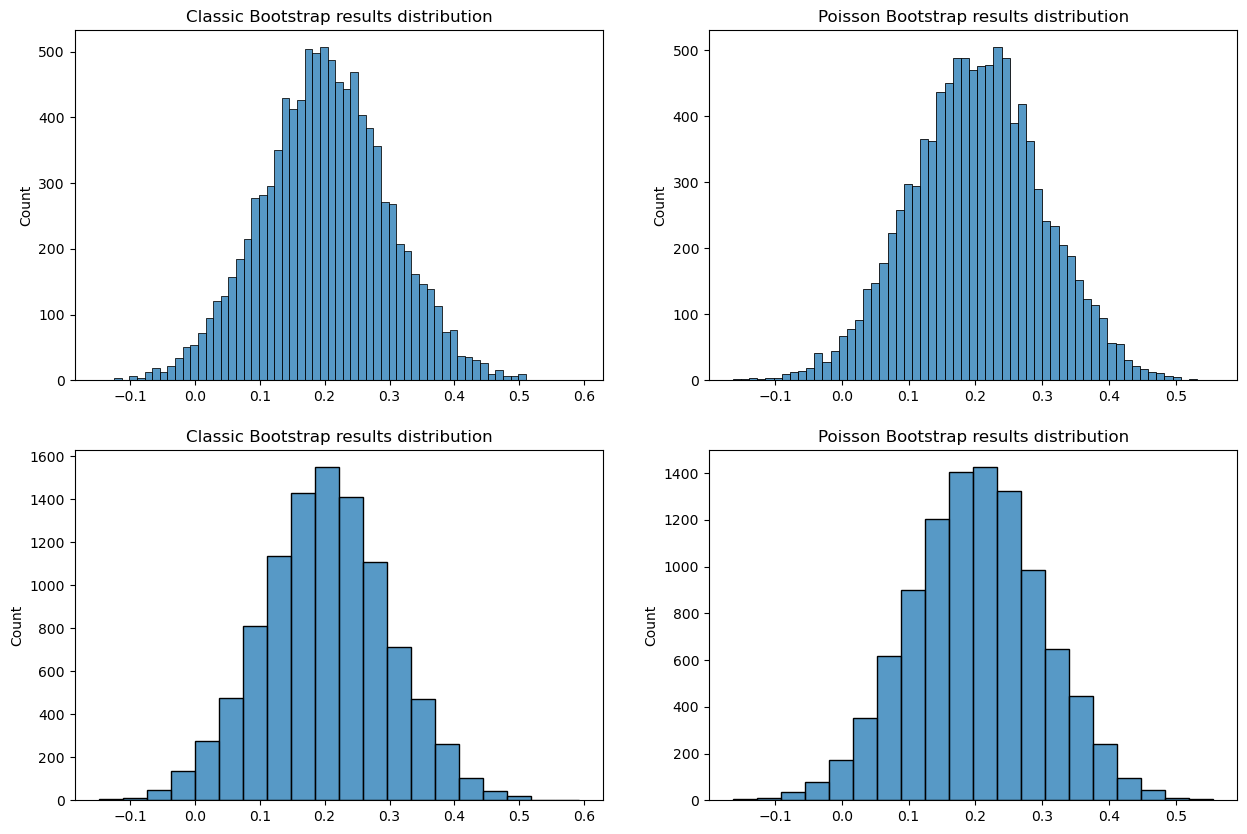

In [179]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(bootstrap_results, ax=ax[0, 0])
ax[0, 0].set_title('Classic Bootstrap results distribution')

sns.histplot(poisson_bootstrap_results, ax=ax[0, 1])
ax[0, 1].set_title('Poisson Bootstrap results distribution')

sns.histplot(bootstrap_results, ax=ax[1, 0], bins=20)
ax[1, 0].set_title('Classic Bootstrap results distribution')

sns.histplot(poisson_bootstrap_results, ax=ax[1, 1], bins=20)
ax[1, 1].set_title('Poisson Bootstrap results distribution')

#### I can be easyly seen that poisson bootstrap is much faster that classical one. And the bigger number of bootstraps(resamples) we need, the better poisson variant performs compared to classical.

## Poisson bootstrap for TP, TN, FP, FN template

In [65]:
N = 100000
B = 1000
labels = np.random.randint(0, 2, N)
predicts = np.random.normal(0.5, 1, N)
predicts = np.clip(predicts, 0, 1)
weights = np.ones(N)

In [66]:
data = list(zip(labels, predicts, weights))

In [67]:
def poisson_bootstrap(
    data: List[Tuple[float, float, float]], 
    B: int, 
    threshold: float) -> List[np.array]:
    
    TP = np.zeros(B)
    FP = np.zeros(B)
    FN = np.zeros(B)
    TN = np.zeros(B)
    
    for label, predict, weight in data:
        predict += np.random.normal(0, 0.05, 1)
        predict = np.clip(predict, 0, 1)
        predict = int(predict >= threshold)
        poisson = np.random.poisson(lam=1, size=B) * weight
        
        if label == 1 and predict == 1:
            TP += poisson
        if label == 0 and predict == 0:
            TN += poisson
        if label == 0 and predict == 1:
            FP += poisson
        if label == 1 and predict == 0:
            FN += poisson
            
    return TP, FP, FN, TN
            

In [68]:
res = poisson_bootstrap(data, B, 0.5)
np.sum(res, axis=1)

array([24925055., 25002708., 25073127., 24999273.])

In [69]:
res = poisson_bootstrap(data, B, 0.7)
np.sum(res, axis=1)

array([21060113., 20990637., 28922933., 29015221.])

In [70]:
res = poisson_bootstrap(data, B, 0.9)
np.sum(res, axis=1)

array([16889213., 16889978., 33103982., 33129349.])

## Bootstrap with p value template

In [6]:
from scipy.stats import norm

In [16]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000, 
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

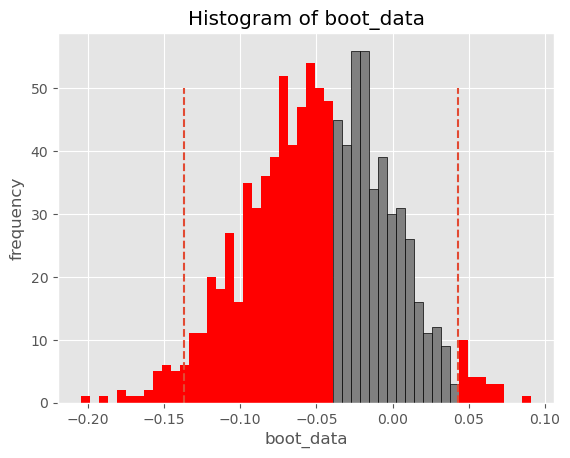

0.2935878501654037

In [31]:
n = 1000
sample_1 = pd.Series(np.random.normal(0.5, 1, n))
sample_2 = pd.Series(np.random.normal(0.5, 1, n))

res = get_bootstrap(
    sample_1,
    sample_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
)

res["p_value"]

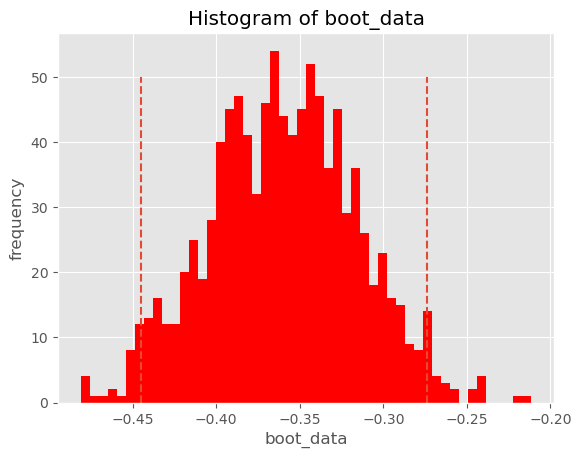

3.2502713143266563e-16

In [39]:
n = 1000
sample_1 = pd.Series(np.random.normal(0.5, 1, n))
sample_2 = pd.Series(np.random.normal(0.5, 1, n) + 0.3)

res = get_bootstrap(
    sample_1,
    sample_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
)

res["p_value"]